In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast

In [3]:
folders = ["noint","normint","tb","pq","tbpq","ovs_tb","ovs_pq","ovs_tbpq","ovspq_swtb","ovstb_swpq"]
workloads = ["a","b","c","d","e","f"]

# insert_noint = pd.read_csv("60minnointerference_separate/stats-per-run-INSERT.csv")

runs = {}

stringconv = lambda x : str(x)
conv = {2:stringconv}

for w in workloads:
    run = {}
    for f in folders:
        run[f] = pd.read_csv(f+"/outputRun"+w+".txt", skiprows=1, header=None, quotechar='"', skipinitialspace=True)
    runs[w] = run

In [4]:
def barPlot(workload,results,operation):
    title = "YCSB Workload "+workload.upper()+" "+operation+" Operation Latency"

    experiment = ["noint","normint","tb","pq","tbpq","ovs_tb","ovs_pq","ovs_tbpq","ovspq_swtb","ovstb_swpq"]

    label_dict = {
            'noint':'No Interference',
            'normint':'Normally Distributed\nInterference',
            'tb':'Token Bucket on Switch',
            'pq':'Priority Queue on Switch',
            'tbpq':'Token Bucket & Priority Queue\non Switch',
            'ovs_tb':'Token Bucket on Host',
            'ovs_pq':'Priority Queue on Host',
            'ovs_tbpq':'Token Bucket & Priority Queue\non Host',
            'ovspq_swtb':'Priority Queue on Host\nToken Bucket on Switch',
            'ovstb_swpq':'Token Bucket on Host\nPriority Queue on Switch'
        }

    labels = []
    min = []
    avg = []
    p95 = []
    p99= []
    max = []

    fields =   ["AverageLatency(us)","MinLatency(us)", "MaxLatency(us)",
    "95thPercentileLatency(us)","99thPercentileLatency(us)"]

    for l in experiment:
        exp = results[l][results[l][0].isin([operation])].reset_index()
        data = exp[2][exp[1].isin(fields)].values
        labels.append(label_dict[l])
        avg.append(data[0])
        min.append(data[1])
        max.append(data[2])
        p95.append(data[3])
        p99.append(data[4])



    labels.reverse()
    avg.reverse()
    p95.reverse()
    p99.reverse()
    min.reverse()
    max.reverse()


    stacked = False

    fig, ax = plt.subplots()
    fig.tight_layout()
    fig.set_figwidth(5)

    x = np.arange(len(labels))

    if not stacked:
        w = 0.25

        ax.barh(x+w, avg, w, label='avg', color='tab:green')
        ax.barh(x, p95, w, label='p95', color='tab:olive')
        ax.barh(x-w, p99, w, label='p99', color='tab:red')

        fig.set_figheight(7)
    else:
        w = 0.8
        
        # ax.barh(labels, min, w, label='min', color='tab:cyan')
        ax.barh(labels, avg, w, label='avg', color='tab:green') #, left=min
        ax.barh(labels, p95, w, label='p95', color='tab:olive', left=avg)
        ax.barh(labels, p99, w, label='p99', color='tab:red', left=p95)
        # ax.barh(labels, max, w, label='max', color='tab:purple', left=p99)

        # fig.set_figheight(5)
        plt.subplots_adjust(wspace=0,hspace=0)
        # ax.set_xscale('log')

    ax.set_xlabel('Operation Latency (us)')
    ax.set_title(title)
    ax.set_yticks(x)
    ax.set_yticklabels(labels)
    ax.legend(loc='center left', bbox_to_anchor=(1.0,0.5))

    plt.show()
    # plt.savefig(plotdata+".png")

In [5]:
filters = ["TOTAL_GC","CLEANUP","OVERALL"]
exp = "noint"


for w in workloads:
    operations = list(runs[w][exp][runs[w][exp][0].str.contains("|".join(filters))==False][0].unique())
    for o in operations:
        print(w,o)
        # barPlot(w,runs[w],o)
        # break
    # break

a [READ]
a [UPDATE]
b [READ]
b [UPDATE]
c [READ]
d [READ]
d [INSERT]
e [INSERT]
e [SCAN]
f [READ]
f [READ-MODIFY-WRITE]
f [UPDATE]


In [28]:
def fixFliers(oldLo, oldHi, p25, p75, fliers):
    """
    :param p25: 25th percentile of the data
    :param p75: 75th percentile of the data
    :param fliers: list of fliers
    :return: lowWhisker, highWhisker, list of fliers
    """
    lowWhisker = p25 - 1.5 * (p75 - p25)
    highWhisker = p75 + 1.5 * (p75 - p25)
    
    lowWhiskerHelper = [f for f in fliers if f >= lowWhisker]
    lowWhisker = min(lowWhiskerHelper+[oldLo])

    highWhiskerHelper = [f for f in fliers if f <= highWhisker]
    highWhisker = max(highWhiskerHelper+[oldHi])



    fliers = [f for f in fliers if f < lowWhisker or f > highWhisker]
    return lowWhisker, highWhisker, fliers



In [29]:
def boxPlot(workload,results,operation,plotOutliers=False):
    title = "YCSB Workload "+workload.upper()+" "+operation+" Operation Latency"

    experiment = ["noint","normint","tb","pq","tbpq","ovs_tb","ovs_pq","ovs_tbpq","ovspq_swtb","ovstb_swpq"]

    label_dict = {
            'noint':'No Interference',
            'normint':'Normally Distributed\nInterference',
            'tb':'Token Bucket on Switch',
            'pq':'Priority Queue on Switch',
            'tbpq':'Token Bucket & Priority Queue\non Switch',
            'ovs_tb':'Token Bucket on Host',
            'ovs_pq':'Priority Queue on Host',
            'ovs_tbpq':'Token Bucket & Priority Queue\non Host',
            'ovspq_swtb':'Priority Queue on Host\nToken Bucket on Switch',
            'ovstb_swpq':'Token Bucket on Host\nPriority Queue on Switch'
        }

    labels = []
    whislo = []
    q1 = []
    med = []
    q3= []
    whishi = []
    fliers = []

    fields =   ["25thPercentileLatency(us)","50thPercentileLatency(us)", "75thPercentileLatency(us)",
    "lowWhisker(us)","highWhisker(us)", "lowOutliers(us)", "highOutliers(us)"]

    for l in experiment:
        exp = results[l][results[l][0].isin([operation])].reset_index()
        data = exp[2][exp[1].isin(fields)].values
        labels.append(label_dict[l])
        q1.append(float(data[0]))
        med.append(float(data[1]))
        q3.append(float(data[2]))
        lo, hi, fli = fixFliers(float(data[3]),float(data[4]),float(data[0]),float(data[2]),ast.literal_eval(data[5])+ast.literal_eval(data[6]))
        # whislo.append(float(data[3]))
        # whishi.append(float(data[4]))
        # data[5] = ast.literal_eval(data[5])
        # data[6] = ast.literal_eval(data[6])
        # fliers.append(data[5] + data[6])
        whislo.append(lo)
        whishi.append(hi)
        fliers.append(fli)

    fig, ax = plt.subplots()
    fig.set_figwidth(8)
    
    boxes = []
    for i in range(len(experiment)):
        box = {
                'label' : labels[i],
                'whislo': whislo[i],
                'q1'    : q1[i],
                'med'   : med[i],
                'q3'    : q3[i],
                'whishi': whishi[i],
                'fliers': fliers[i]
            }
        boxes.append(box)
    
    boxes.reverse()
    ax.bxp(boxes,showfliers=plotOutliers,vert=False)

        
    # ax.set_xscale('log')
    ax.set_xlabel('Operation Latency (us)')
    ax.set_title(title)
    ax.set_xlim(left=0)
    # ax.legend(loc='center left', bbox_to_anchor=(1.0,0.5))
    plt.savefig(title+"_box.png", bbox_inches="tight")
    plt.show()
    

a [READ]


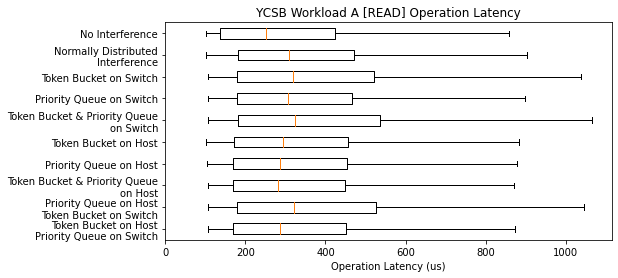

a [UPDATE]


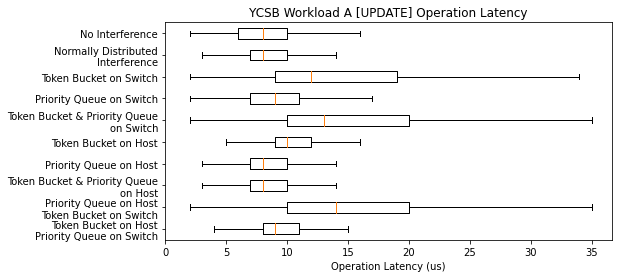

b [READ]


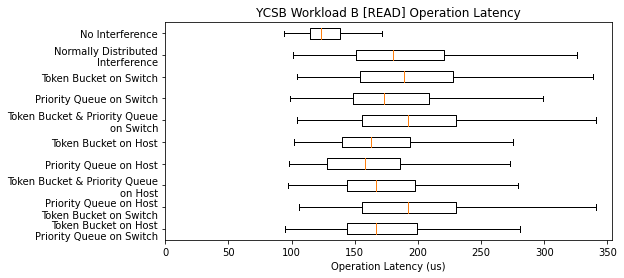

b [UPDATE]


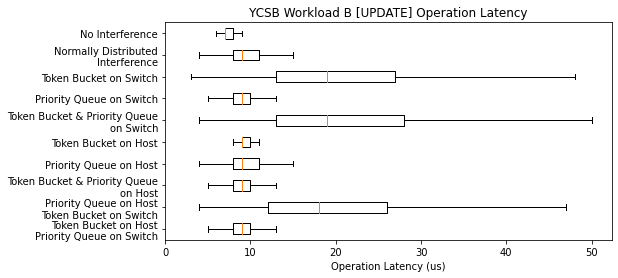

c [READ]


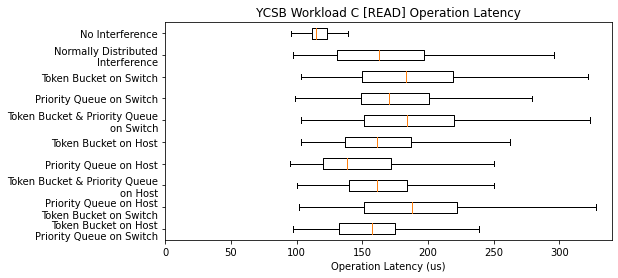

d [READ]


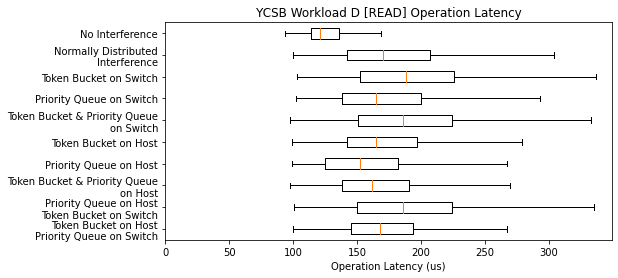

d [INSERT]


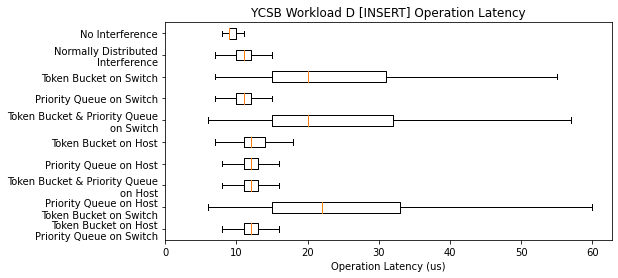

e [INSERT]


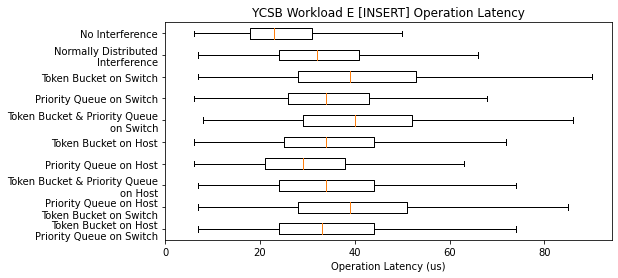

e [SCAN]


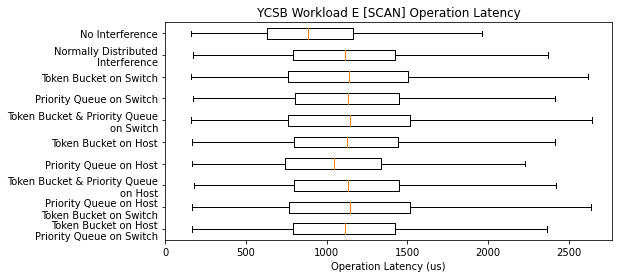

f [READ]


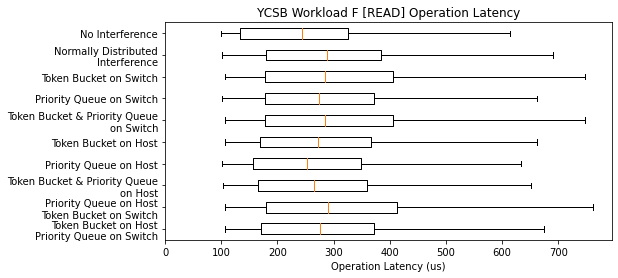

f [READ-MODIFY-WRITE]


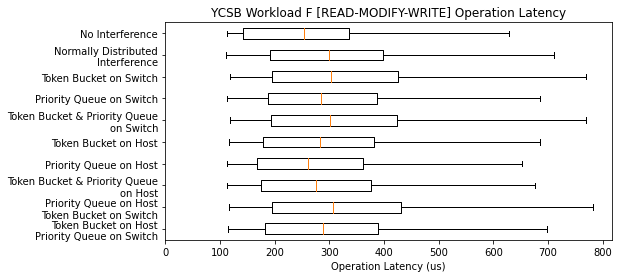

f [UPDATE]


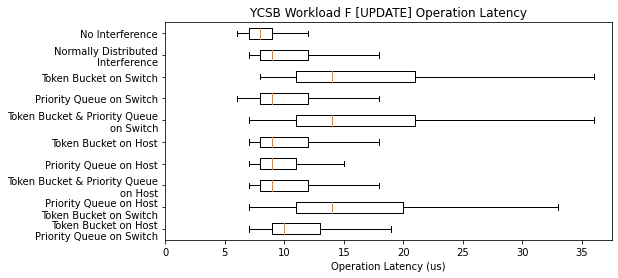

In [30]:
filters = ["TOTAL_GC","CLEANUP","OVERALL"]
exp = "noint"


for w in workloads:
    operations = list(runs[w][exp][runs[w][exp][0].str.contains("|".join(filters))==False][0].unique())
    for o in operations:
        print(w,o)
        boxPlot(w,runs[w],o,plotOutliers=False)
        # break
    # break

In [9]:
def barPlot_med(workload,results,operation):
    title = "YCSB Workload "+workload.upper()+" "+operation+" Operation Latency"
    
    experiment = ["noint","normint","tb","pq","tbpq","ovs_tb","ovs_pq","ovs_tbpq","ovspq_swtb","ovstb_swpq"]

    label_dict = {
            'noint':'No Interference',
            'normint':'Normally Distributed\nInterference',
            'tb':'Token Bucket on Switch',
            'pq':'Priority Queue on Switch',
            'tbpq':'Token Bucket & Priority Queue\non Switch',
            'ovs_tb':'Token Bucket on Host',
            'ovs_pq':'Priority Queue on Host',
            'ovs_tbpq':'Token Bucket & Priority Queue\non Host',
            'ovspq_swtb':'Priority Queue on Host\nToken Bucket on Switch',
            'ovstb_swpq':'Token Bucket on Host\nPriority Queue on Switch'
        }

    labels = []
    min = []
    p50 = []
    p95 = []
    p99 = []
    p999 = []
    max = []

    fields =   ["50thPercentileLatency(us)","MinLatency(us)", "MaxLatency(us)",
    "95thPercentileLatency(us)","99thPercentileLatency(us)","99.9PercentileLatency(us)"]

    for l in experiment:
        exp = results[l][results[l][0].isin([operation])].reset_index()
        data = exp[2][exp[1].isin(fields)].values
        labels.append(label_dict[l])
        p50.append(float(data[0]))
        min.append(float(data[1]))
        max.append(float(data[2]))
        p95.append(float(data[3]))
        p99.append(float(data[4]))
        p999.append(float(data[5]))



    labels.reverse()
    p50.reverse()
    p95.reverse()
    p99.reverse()
    p999.reverse()
    min.reverse()
    max.reverse()


    stacked = False

    fig, ax = plt.subplots()
    fig.tight_layout()
    fig.set_figwidth(5)

    x = np.arange(len(labels))

    if not stacked:
        w = 0.1

        ax.barh(x+1.5*w, p50, w, label='p50', color='tab:green')
        ax.barh(x+0.5*w, p95, w, label='p95', color='tab:olive')
        ax.barh(x-0.5*w, p99, w, label='p99', color='tab:red')
        ax.barh(x-1.5*w, p999, w, label='p999', color='tab:purple')

        fig.set_figheight(4)
    else:
        w = 0.8
        
        # ax.barh(labels, min, w, label='min', color='tab:cyan')
        ax.barh(labels, p50, w, label='p50', color='tab:green') #, left=min
        ax.barh(labels, p95, w, label='p95', color='tab:olive', left=p50)
        ax.barh(labels, p99, w, label='p99', color='tab:red', left=p95)
        # ax.barh(labels, p999, w, label='p999', color='tab:purple', left=p99)
        # ax.barh(labels, max, w, label='max', color='tab:purple', left=p99)

        # fig.set_figheight(5)
        plt.subplots_adjust(wspace=0,hspace=0)
        # ax.set_xscale('log')

    ax.set_xlabel('Operation Latency (us)')
    # ax.set_xlim(left=0)
    ax.set_title(title)
    ax.set_yticks(x)
    ax.set_yticklabels(labels)
    ax.legend(loc='center left', bbox_to_anchor=(1.0,0.5))

    # plt.savefig(title+".png", bbox_inches="tight")
    plt.show()
    

In [10]:
def latexTable(workloads,results,operation):
    title = "YCSB Workload "+workloads.upper()+" "+operation+" Operation Latency"
 
    experiment = ["noint","normint","tb","pq","tbpq","ovs_tb","ovs_pq","ovs_tbpq","ovspq_swtb","ovstb_swpq"]

    label_dict = {
            'noint':'No Interference',
            'normint':'Normally Distributed Interference',
            'tb':'Token Bucket on Switch',
            'pq':'Priority Queue on Switch',
            'tbpq':'Token Bucket \& Priority Queue on Switch',
            'ovs_tb':'Token Bucket on Host',
            'ovs_pq':'Priority Queue on Host',
            'ovs_tbpq':'Token Bucket \& Priority Queue on Host',
            'ovspq_swtb':'Priority Queue on Host, Token Bucket on Switch',
            'ovstb_swpq':'Token Bucket on Host, Priority Queue on Switch'
    }
    
    fields =   ["50thPercentileLatency(us)","MinLatency(us)", "MaxLatency(us)",
    "95thPercentileLatency(us)","99thPercentileLatency(us)","99.9PercentileLatency(us)"]


    print("\\begin{table}[H]")
    print("\\centering")
    print("\\begin{tabular}{|l|l|l|l|}")# name, p95,p99,p999
    print("\\hline")
    print("\\textbf{Experiment} & \\textbf{P95} & \\textbf{P99} & \\textbf{P99.9} \\\\ \\hline")


    for l in experiment:
        exp = results[l][results[l][0].isin([operation])].reset_index()
        data = exp[2][exp[1].isin(fields)].values
        # labels.append(label_dict[l])
        # p50.append(float(data[0]))
        # min.append(float(data[1]))
        # max.append(float(data[2]))
        # p95.append(float(data[3]))
        # p99.append(float(data[4]))
        # p999.append(float(data[5]))

        # print(label_dict[l] + " & " + data[3] + " & " + data[4] + " & " + data[5] + "\\\\ \\hline")
        print(label_dict[l],end=' & ')
        print(data[3],end=' & ')

        if(float(data[4]) > float(data[3])*10):
            print("\\textbf{"+data[4]+"}",end=' & ')
        else:
            print(data[4],end=' & ')

        if(float(data[5]) > float(data[3])*10):
            print("\\textbf{"+data[5]+"}",end='')
        else:
            print(data[5],end='')

        print("\\\\ \\hline")

    print("\\end{tabular}")
    print("\\caption{"+title+"}")
    print("\\label{tab:todo}")
    print("\\end{table}")
    print("\n\n")

a [READ]


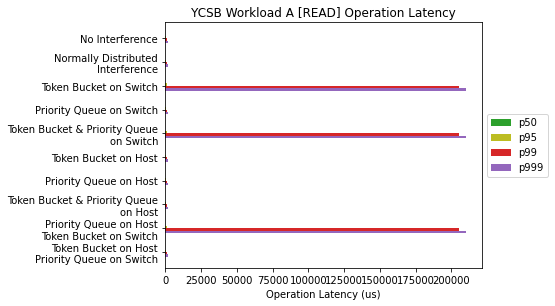

\begin{table}[H]
\centering
\begin{tabular}{|l|l|l|l|}
\hline
\textbf{Experiment} & \textbf{P95} & \textbf{P99} & \textbf{P99.9} \\ \hline
No Interference & 763 & 1138 & 1716\\ \hline
Normally Distributed Interference & 843 & 1209 & 1821\\ \hline
Token Bucket on Switch & 1125 & \textbf{205567} & \textbf{210559}\\ \hline
Priority Queue on Switch & 843 & 1223 & 1870\\ \hline
Token Bucket \& Priority Queue on Switch & 1144 & \textbf{205567} & \textbf{210559}\\ \hline
Token Bucket on Host & 819 & 1184 & 1816\\ \hline
Priority Queue on Host & 825 & 1202 & 1806\\ \hline
Token Bucket \& Priority Queue on Host & 812 & 1179 & 1761\\ \hline
Priority Queue on Host, Token Bucket on Switch & 1135 & \textbf{205567} & \textbf{210303}\\ \hline
Token Bucket on Host, Priority Queue on Switch & 821 & 1202 & 1868\\ \hline
\end{tabular}
\caption{YCSB Workload A [READ] Operation Latency}
\label{tab:todo}
\end{table}



a [UPDATE]


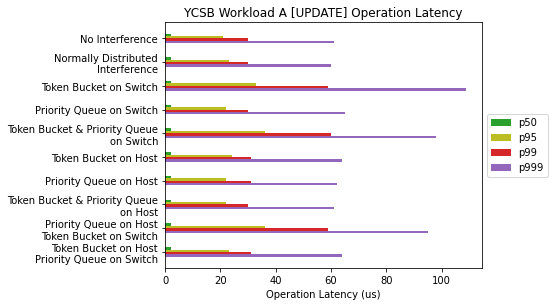

\begin{table}[H]
\centering
\begin{tabular}{|l|l|l|l|}
\hline
\textbf{Experiment} & \textbf{P95} & \textbf{P99} & \textbf{P99.9} \\ \hline
No Interference & 21 & 30 & 61\\ \hline
Normally Distributed Interference & 23 & 30 & 60\\ \hline
Token Bucket on Switch & 33 & 59 & 109\\ \hline
Priority Queue on Switch & 22 & 30 & 65\\ \hline
Token Bucket \& Priority Queue on Switch & 36 & 60 & 98\\ \hline
Token Bucket on Host & 24 & 31 & 64\\ \hline
Priority Queue on Host & 22 & 31 & 62\\ \hline
Token Bucket \& Priority Queue on Host & 22 & 30 & 61\\ \hline
Priority Queue on Host, Token Bucket on Switch & 36 & 59 & 95\\ \hline
Token Bucket on Host, Priority Queue on Switch & 23 & 31 & 64\\ \hline
\end{tabular}
\caption{YCSB Workload A [UPDATE] Operation Latency}
\label{tab:todo}
\end{table}



b [READ]


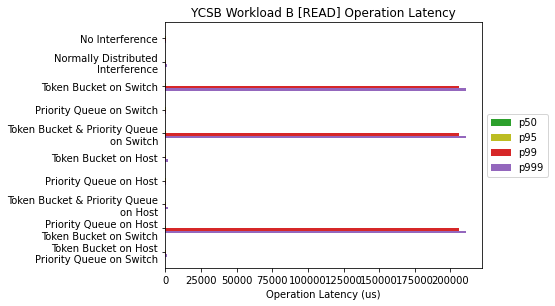

\begin{table}[H]
\centering
\begin{tabular}{|l|l|l|l|}
\hline
\textbf{Experiment} & \textbf{P95} & \textbf{P99} & \textbf{P99.9} \\ \hline
No Interference & 246 & 360 & 551\\ \hline
Normally Distributed Interference & 440 & 633 & 937\\ \hline
Token Bucket on Switch & 430 & \textbf{205695} & \textbf{211199}\\ \hline
Priority Queue on Switch & 389 & 536 & 759\\ \hline
Token Bucket \& Priority Queue on Switch & 429 & \textbf{205823} & \textbf{211071}\\ \hline
Token Bucket on Host & 394 & 856 & 1947\\ \hline
Priority Queue on Host & 318 & 449 & 681\\ \hline
Token Bucket \& Priority Queue on Host & 391 & 653 & 1708\\ \hline
Priority Queue on Host, Token Bucket on Switch & 428 & \textbf{205695} & \textbf{210687}\\ \hline
Token Bucket on Host, Priority Queue on Switch & 392 & 626 & 1610\\ \hline
\end{tabular}
\caption{YCSB Workload B [READ] Operation Latency}
\label{tab:todo}
\end{table}



b [UPDATE]


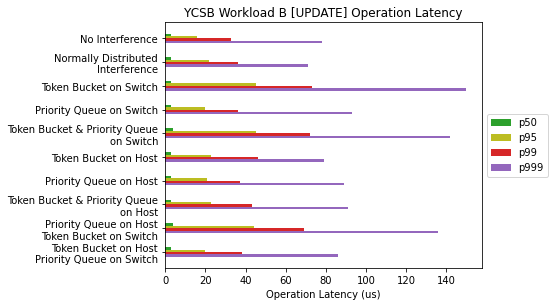

\begin{table}[H]
\centering
\begin{tabular}{|l|l|l|l|}
\hline
\textbf{Experiment} & \textbf{P95} & \textbf{P99} & \textbf{P99.9} \\ \hline
No Interference & 16 & 33 & 78\\ \hline
Normally Distributed Interference & 22 & 36 & 71\\ \hline
Token Bucket on Switch & 45 & 73 & 150\\ \hline
Priority Queue on Switch & 20 & 36 & 93\\ \hline
Token Bucket \& Priority Queue on Switch & 45 & 72 & 142\\ \hline
Token Bucket on Host & 23 & 46 & 79\\ \hline
Priority Queue on Host & 21 & 37 & 89\\ \hline
Token Bucket \& Priority Queue on Host & 23 & 43 & 91\\ \hline
Priority Queue on Host, Token Bucket on Switch & 44 & 69 & 136\\ \hline
Token Bucket on Host, Priority Queue on Switch & 20 & 38 & 86\\ \hline
\end{tabular}
\caption{YCSB Workload B [UPDATE] Operation Latency}
\label{tab:todo}
\end{table}



c [READ]


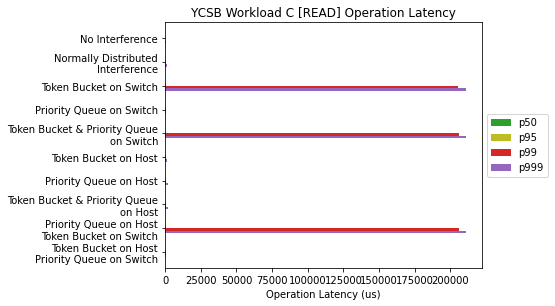

\begin{table}[H]
\centering
\begin{tabular}{|l|l|l|l|}
\hline
\textbf{Experiment} & \textbf{P95} & \textbf{P99} & \textbf{P99.9} \\ \hline
No Interference & 143 & 174 & 427\\ \hline
Normally Distributed Interference & 289 & 510 & 1064\\ \hline
Token Bucket on Switch & 341 & \textbf{205695} & \textbf{211071}\\ \hline
Priority Queue on Switch & 284 & 479 & 624\\ \hline
Token Bucket \& Priority Queue on Switch & 340 & \textbf{205823} & \textbf{210815}\\ \hline
Token Bucket on Host & 329 & 650 & 1491\\ \hline
Priority Queue on Host & 232 & 495 & 2009\\ \hline
Token Bucket \& Priority Queue on Host & 258 & 588 & 1667\\ \hline
Priority Queue on Host, Token Bucket on Switch & 347 & \textbf{205823} & \textbf{211327}\\ \hline
Token Bucket on Host, Priority Queue on Switch & 222 & 388 & 601\\ \hline
\end{tabular}
\caption{YCSB Workload C [READ] Operation Latency}
\label{tab:todo}
\end{table}



d [READ]


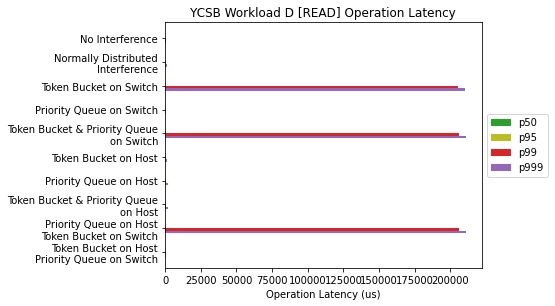

\begin{table}[H]
\centering
\begin{tabular}{|l|l|l|l|}
\hline
\textbf{Experiment} & \textbf{P95} & \textbf{P99} & \textbf{P99.9} \\ \hline
No Interference & 205 & 287 & 485\\ \hline
Normally Distributed Interference & 378 & 688 & 1513\\ \hline
Token Bucket on Switch & 400 & \textbf{205695} & \textbf{210559}\\ \hline
Priority Queue on Switch & 376 & 535 & 759\\ \hline
Token Bucket \& Priority Queue on Switch & 432 & \textbf{205823} & \textbf{211071}\\ \hline
Token Bucket on Host & 419 & 644 & 1096\\ \hline
Priority Queue on Host & 304 & 528 & 1716\\ \hline
Token Bucket \& Priority Queue on Host & 377 & 585 & 1714\\ \hline
Priority Queue on Host, Token Bucket on Switch & 436 & \textbf{205823} & \textbf{211327}\\ \hline
Token Bucket on Host, Priority Queue on Switch & 344 & 559 & 868\\ \hline
\end{tabular}
\caption{YCSB Workload D [READ] Operation Latency}
\label{tab:todo}
\end{table}



d [INSERT]


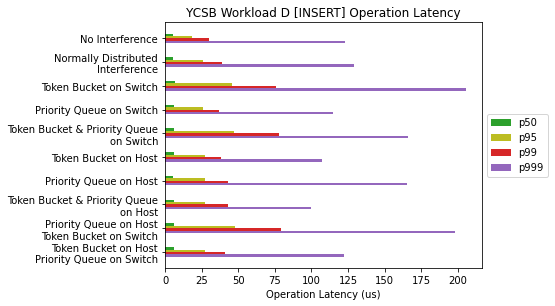

\begin{table}[H]
\centering
\begin{tabular}{|l|l|l|l|}
\hline
\textbf{Experiment} & \textbf{P95} & \textbf{P99} & \textbf{P99.9} \\ \hline
No Interference & 18 & 30 & 123\\ \hline
Normally Distributed Interference & 26 & 39 & 129\\ \hline
Token Bucket on Switch & 46 & 76 & 206\\ \hline
Priority Queue on Switch & 26 & 37 & 115\\ \hline
Token Bucket \& Priority Queue on Switch & 47 & 78 & 166\\ \hline
Token Bucket on Host & 27 & 38 & 107\\ \hline
Priority Queue on Host & 27 & 43 & 165\\ \hline
Token Bucket \& Priority Queue on Host & 27 & 43 & 100\\ \hline
Priority Queue on Host, Token Bucket on Switch & 48 & 79 & 198\\ \hline
Token Bucket on Host, Priority Queue on Switch & 27 & 41 & 122\\ \hline
\end{tabular}
\caption{YCSB Workload D [INSERT] Operation Latency}
\label{tab:todo}
\end{table}



e [INSERT]


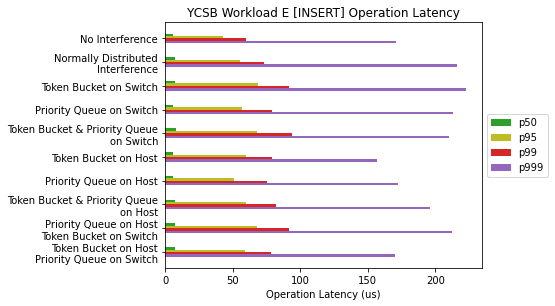

\begin{table}[H]
\centering
\begin{tabular}{|l|l|l|l|}
\hline
\textbf{Experiment} & \textbf{P95} & \textbf{P99} & \textbf{P99.9} \\ \hline
No Interference & 43 & 60 & 171\\ \hline
Normally Distributed Interference & 55 & 73 & 216\\ \hline
Token Bucket on Switch & 69 & 92 & 223\\ \hline
Priority Queue on Switch & 57 & 79 & 213\\ \hline
Token Bucket \& Priority Queue on Switch & 68 & 94 & 210\\ \hline
Token Bucket on Host & 60 & 79 & 157\\ \hline
Priority Queue on Host & 51 & 75 & 172\\ \hline
Token Bucket \& Priority Queue on Host & 60 & 82 & 196\\ \hline
Priority Queue on Host, Token Bucket on Switch & 68 & 92 & 212\\ \hline
Token Bucket on Host, Priority Queue on Switch & 59 & 78 & 170\\ \hline
\end{tabular}
\caption{YCSB Workload E [INSERT] Operation Latency}
\label{tab:todo}
\end{table}



e [SCAN]


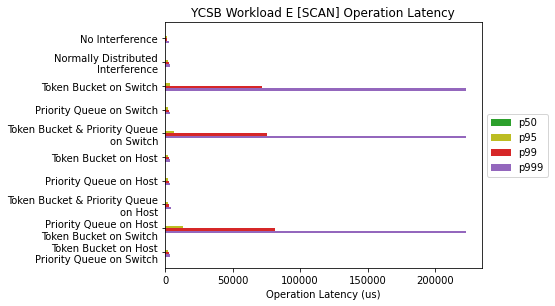

\begin{table}[H]
\centering
\begin{tabular}{|l|l|l|l|}
\hline
\textbf{Experiment} & \textbf{P95} & \textbf{P99} & \textbf{P99.9} \\ \hline
No Interference & 1448 & 1680 & 2507\\ \hline
Normally Distributed Interference & 1933 & 2809 & 3633\\ \hline
Token Bucket on Switch & 3641 & \textbf{71743} & \textbf{222975}\\ \hline
Priority Queue on Switch & 1961 & 2833 & 3657\\ \hline
Token Bucket \& Priority Queue on Switch & 6407 & \textbf{75775} & \textbf{223359}\\ \hline
Token Bucket on Host & 1906 & 2871 & 3875\\ \hline
Priority Queue on Host & 1788 & 2573 & 3523\\ \hline
Token Bucket \& Priority Queue on Host & 1966 & 3055 & 3949\\ \hline
Priority Queue on Host, Token Bucket on Switch & 13063 & 81087 & \textbf{223103}\\ \hline
Token Bucket on Host, Priority Queue on Switch & 1936 & 2889 & 3753\\ \hline
\end{tabular}
\caption{YCSB Workload E [SCAN] Operation Latency}
\label{tab:todo}
\end{table}



f [READ]


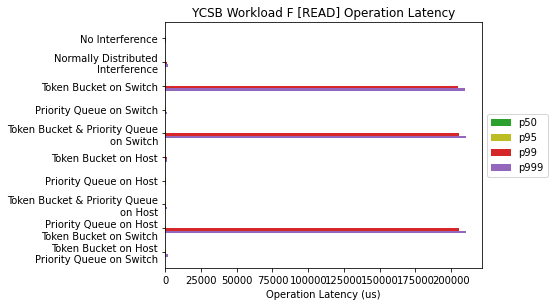

\begin{table}[H]
\centering
\begin{tabular}{|l|l|l|l|}
\hline
\textbf{Experiment} & \textbf{P95} & \textbf{P99} & \textbf{P99.9} \\ \hline
No Interference & 398 & 470 & 665\\ \hline
Normally Distributed Interference & 523 & 927 & 1621\\ \hline
Token Bucket on Switch & 627 & \textbf{205055} & \textbf{209791}\\ \hline
Priority Queue on Switch & 467 & 651 & 1111\\ \hline
Token Bucket \& Priority Queue on Switch & 629 & \textbf{205183} & \textbf{210687}\\ \hline
Token Bucket on Host & 518 & 911 & 1524\\ \hline
Priority Queue on Host & 426 & 559 & 846\\ \hline
Token Bucket \& Priority Queue on Host & 469 & 765 & 1378\\ \hline
Priority Queue on Host, Token Bucket on Switch & 634 & \textbf{205183} & \textbf{210175}\\ \hline
Token Bucket on Host, Priority Queue on Switch & 497 & 785 & 1628\\ \hline
\end{tabular}
\caption{YCSB Workload F [READ] Operation Latency}
\label{tab:todo}
\end{table}



f [READ-MODIFY-WRITE]


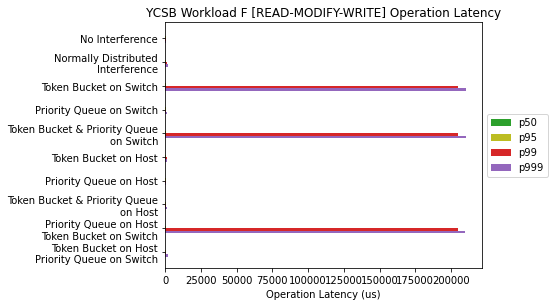

\begin{table}[H]
\centering
\begin{tabular}{|l|l|l|l|}
\hline
\textbf{Experiment} & \textbf{P95} & \textbf{P99} & \textbf{P99.9} \\ \hline
No Interference & 414 & 488 & 686\\ \hline
Normally Distributed Interference & 539 & 951 & 1645\\ \hline
Token Bucket on Switch & 655 & \textbf{205055} & \textbf{210175}\\ \hline
Priority Queue on Switch & 483 & 665 & 1150\\ \hline
Token Bucket \& Priority Queue on Switch & 656 & \textbf{205183} & \textbf{210815}\\ \hline
Token Bucket on Host & 537 & 937 & 1579\\ \hline
Priority Queue on Host & 441 & 574 & 866\\ \hline
Token Bucket \& Priority Queue on Host & 487 & 780 & 1429\\ \hline
Priority Queue on Host, Token Bucket on Switch & 661 & \textbf{205183} & \textbf{209919}\\ \hline
Token Bucket on Host, Priority Queue on Switch & 514 & 806 & 1672\\ \hline
\end{tabular}
\caption{YCSB Workload F [READ-MODIFY-WRITE] Operation Latency}
\label{tab:todo}
\end{table}



f [UPDATE]


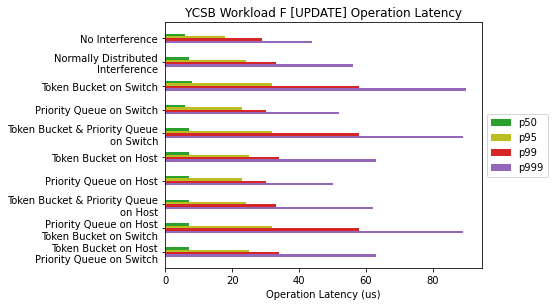

\begin{table}[H]
\centering
\begin{tabular}{|l|l|l|l|}
\hline
\textbf{Experiment} & \textbf{P95} & \textbf{P99} & \textbf{P99.9} \\ \hline
No Interference & 18 & 29 & 44\\ \hline
Normally Distributed Interference & 24 & 33 & 56\\ \hline
Token Bucket on Switch & 32 & 58 & 90\\ \hline
Priority Queue on Switch & 23 & 30 & 52\\ \hline
Token Bucket \& Priority Queue on Switch & 32 & 58 & 89\\ \hline
Token Bucket on Host & 25 & 34 & 63\\ \hline
Priority Queue on Host & 23 & 30 & 50\\ \hline
Token Bucket \& Priority Queue on Host & 24 & 33 & 62\\ \hline
Priority Queue on Host, Token Bucket on Switch & 32 & 58 & 89\\ \hline
Token Bucket on Host, Priority Queue on Switch & 25 & 34 & 63\\ \hline
\end{tabular}
\caption{YCSB Workload F [UPDATE] Operation Latency}
\label{tab:todo}
\end{table}





In [11]:
filters = ["TOTAL_GC","CLEANUP","OVERALL"]
exp = "noint"


for w in workloads:
    operations = list(runs[w][exp][runs[w][exp][0].str.contains("|".join(filters))==False][0].unique())
    for o in operations:
        print(w,o)
        barPlot_med(w,runs[w],o)
        latexTable(w,runs[w],o)
        # break
    # break

In [12]:
runs[workloads[0]]['pq']

,0,1,2
0,[OVERALL],RunTime(ms),189624
1,[OVERALL],Throughput(ops/sec),5273.594059823651
2,[TOTAL_GCS_G1_Young_Generation],Count,9
3,[TOTAL_GC_TIME_G1_Young_Generation],Time(ms),36
4,[TOTAL_GC_TIME_%_G1_Young_Generation],Time(%),0.018984938615365144
5,[TOTAL_GCS_G1_Old_Generation],Count,0
6,[TOTAL_GC_TIME_G1_Old_Generation],Time(ms),0
7,[TOTAL_GC_TIME_%_G1_Old_Generation],Time(%),0.0
8,[TOTAL_GCs],Count,9
9,[TOTAL_GC_TIME],Time(ms),36
